<a href="https://colab.research.google.com/github/rudycav/Digital-Assets-Prediction-Model/blob/main/Project/%20Crypto_forecast_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import numpy as np
import math
import requests
import pandas as pd
import matplotlib.pylab as plt
#%matplotlib widget
#from google.colab import output
#output.enable_custom_widget_manager()

from datetime import datetime
from datetime import datetime, timedelta
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.svm import SVC
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from scipy.stats import sem

In [23]:
symbol = 'ETH'

def get_crypto_price(symbol, exchange, start_date = None):
    api_key = ' E7KN41UXPEIKWXIK'
    api_url = f'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol={symbol}&market={exchange}&apikey={api_key}'
    raw_df = requests.get(api_url).json()
    df = pd.DataFrame(raw_df['Time Series (Digital Currency Daily)']).T
    df = df.rename(columns = {'1a. open (USD)': 'open', '2a. high (USD)': 'high', '3a. low (USD)': 'low', '4a. close (USD)': 'close', '5. volume': 'volume'})
    df.index.names = ['Date']
 

    for i in df.columns:
        df[i] = df[i].astype(float)
    df.index = pd.to_datetime(df.index)
    df = df.iloc[::-1].drop(['1b. open (USD)', '2b. high (USD)', '3b. low (USD)', '4b. close (USD)', '6. market cap (USD)'], axis = 1)

    if start_date:
        df = df[df.index >= start_date]
    return df

crypto_df = get_crypto_price(symbol = symbol, exchange = 'USD', start_date = '2015-05-01')
crypto_df.head()

,open,high,low,close,volume
Date,,,,,
2019-11-13,187.09,189.66,185.30,188.11,197273.84001
2019-11-14,188.07,188.72,183.34,184.92,245505.29971
2019-11-15,184.93,186.70,177.67,180.00,407466.78964
2019-11-16,179.99,183.46,179.30,182.37,172801.52576
2019-11-17,182.37,186.09,180.00,183.82,198892.43720


In [24]:
forecast_days = 17

def create_prediction_column(df):
  crypto_df['forecast'] = crypto_df[['high']].shift(-forecast_days)

  return crypto_df

prediction_column = create_prediction_column(crypto_df)
prediction_column.tail()

,open,high,low,close,volume,forecast
Date,,,,,,
2022-08-04,1618.16,1662.79,1580.39,1607.96,7.355522e+05,NaN
2022-08-05,1607.97,1742.07,1605.64,1736.81,1.005846e+06,NaN
2022-08-06,1736.81,1749.93,1685.26,1690.60,5.233146e+05,NaN
2022-08-07,1690.60,1729.79,1668.00,1700.19,4.399048e+05,NaN
2022-08-08,1700.20,1720.00,1695.00,1705.98,1.887278e+04,NaN


In [25]:
def smooth_data(data, alpha):

    return data.ewm(alpha=alpha).mean()

expo_smooth = smooth_data(prediction_column, 0.65)


In [26]:
def create_dataset(df):
  independent_dataset = np.array(prediction_column.high)
  independent_dataset = independent_dataset[:-forecast_days]

  dependent_dataset = prediction_column.forecast.values
  dependent_dataset = dependent_dataset[:-forecast_days]

  return independent_dataset, dependent_dataset

x_dataset, y_dataset = create_dataset(expo_smooth)

In [27]:
x_dataset.shape

(983,)

In [28]:
y_dataset.shape

(983,)

In [29]:
def split_data(X_data, y_data, test_size):
  X_train, X_test, y_train, y_test = train_test_split(x_dataset, y_dataset, test_size = 0.3)

  return X_train.reshape(-1, 1), X_test.reshape(-1, 1), y_train, y_test

X_train, X_test, y_train, y_test = split_data(x_dataset, y_dataset, test_size=0.3)

In [30]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((688, 1), (295, 1), (688,), (295,))

In [31]:
def regression_model(X_train, y_train, X_test, y_test):
  lin_reg_model = LinearRegression()
  lin_reg_model.fit(X_train, y_train)

  score_acc = lin_reg_model.score(X_test, y_test)
  score_acc = round(score_acc,2)
  score_acc

  return lin_reg_model, score_acc

linear_regression_model, accuracy_score = regression_model(X_train, y_train, X_test, y_test)

In [32]:
print(f'Model accuracy score: {accuracy_score}')

Model accuracy score: 0.9


In [33]:
def model_results(df):
  actual_price = np.array(crypto_df[['high']])
  model_predictions = linear_regression_model.predict(actual_price)

  model_predictions_df = pd.DataFrame(model_predictions, columns=['Model Results'])
  model_predictions_df.index.name = 'Date'
  model_predictions_df.index = crypto_df.index

  return model_predictions_df

model_predictions_df = (model_results(crypto_df))


In [34]:
model_predictions_df.head()

,Model Results
Date,
2019-11-13,303.424800
2019-11-14,302.536925
2019-11-15,300.628938
2019-11-16,297.568604
2019-11-17,300.052764


In [35]:
def create_prediction(df):
  actual_price = np.array(crypto_df[['high']])[-forecast_days:]
  forecast_prediction = linear_regression_model.predict(actual_price)

  return forecast_prediction

forecast_prediction = (create_prediction(crypto_df))


In [36]:
forecast_prediction

array([1632.26169528, 1696.33036404, 1644.57859696, 1497.75810645,
       1677.53386532, 1810.10113142, 1792.34363514, 1772.3758973 ,
       1781.67024642, 1734.43341722, 1709.23288527, 1715.87305542,
       1694.86631514, 1769.75005477, 1777.17419949, 1758.15100932,
       1748.90388759])

In [37]:
def get_future_dates(datetime):
  future_dates = []

  datetime = datetime

  for i in range(forecast_days): 
    datetime += timedelta(days=1)
    future_dates.append(datetime.strftime('%Y-%m-%d'))

  return future_dates

future_dates = get_future_dates(datetime.now())

In [38]:
def datetime_index(forecast_df, crypto_df):

  forecast_df = pd.DataFrame(forecast_prediction, columns=['forecast'])
  forecast_df['Date'] = future_dates
  forecast_df.set_index('Date', inplace=True)
  forecast_df.index = pd.to_datetime(forecast_df.index)
  crypto_df.index = pd.to_datetime(crypto_df.index)

  return forecast_df, crypto_df

forecast_df, crypto_df = datetime_index(future_dates, crypto_df)

In [39]:
print(forecast_df.head())

               forecast
Date                   
2022-08-09  1632.261695
2022-08-10  1696.330364
2022-08-11  1644.578597
2022-08-12  1497.758106
2022-08-13  1677.533865


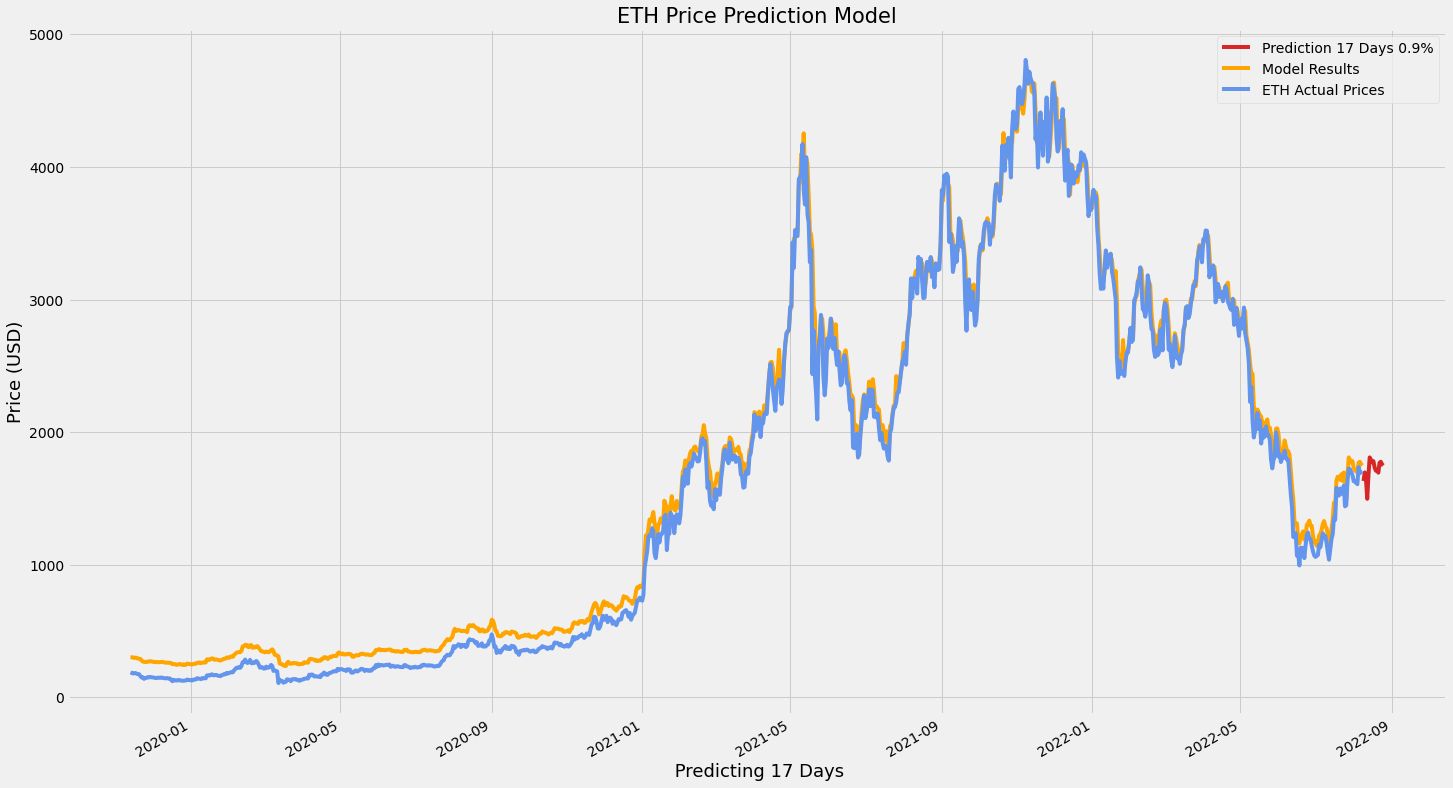

<module 'matplotlib.pylab' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pylab.py'>

In [40]:
import matplotlib.dates as mdates

def plot_model():
  plt.figure(figsize=(22,14))
  plt.plot(forecast_df.forecast, color='tab:red', label = f'Prediction {forecast_days} Days {accuracy_score}%')
  plt.plot(model_predictions_df, color='orange', label = 'Model Results')
  plt.plot(crypto_df.close, color='cornflowerblue', label = f'{symbol} Actual Prices')
  plt.title(f'{symbol} Price Prediction Model', fontsize=21)
  plt.xlabel(f' Predicting {forecast_days} Days', fontsize=18)
  plt.ylabel('Price (USD)', fontsize=18)
  plt.legend(loc='upper right')
  plt.gcf().autofmt_xdate()

  plt.show()

  return plt

plot_model()

In [41]:
forecast_df.style.background_gradient(axis=None, low=0.75, high=2)

,forecast
Date,
2022-08-09 00:00:00,1632.261695
2022-08-10 00:00:00,1696.330364
2022-08-11 00:00:00,1644.578597
2022-08-12 00:00:00,1497.758106
2022-08-13 00:00:00,1677.533865
2022-08-14 00:00:00,1810.101131
2022-08-15 00:00:00,1792.343635
2022-08-16 00:00:00,1772.375897
2022-08-17 00:00:00,1781.670246
